In [1]:
# Cell 1: Load Libraries and Test
library(fda)
library(ncdf4)

# Test that libraries loaded correctly
cat("Libraries loaded successfully\n")

Loading required package: splines

Loading required package: fds

Loading required package: rainbow

Loading required package: MASS

Loading required package: pcaPP

Loading required package: RCurl

Loading required package: deSolve


Attaching package: 'fda'


The following object is masked from 'package:graphics':

    matplot




Libraries loaded successfully


In [2]:
# Cell 2: ANOVA Test Function + Test
anova_test_univariate <- function(X, Y, p = 9) {
   n = length(X)
   if(n <= p || p < 3) return(0)
   
   xi = Y[order(X)]
   max_windows = n - p + 1
   if(max_windows <= 0) return(0)
   
   V = matrix(0, max_windows, p)
   valid_windows = 0
   
   start_idx = max(1, ceiling((p+1)/2))
   end_idx = min(n, n - ceiling((p+1)/2) + 1)
   
   for(ind in start_idx:end_idx) {
     window_start = max(1, ind - floor((p-1)/2))
     window_end = min(n, ind + floor((p-1)/2))
     window_size = window_end - window_start + 1
     
     if(window_size == p) {
       valid_windows = valid_windows + 1
       V[valid_windows, ] = xi[window_start:window_end]
     }
   }
   
   if(valid_windows <= 1) return(0)
   
   V = V[1:valid_windows, , drop=FALSE]
   nv = valid_windows
   
   grand_mean = mean(V)
   row_means = rowMeans(V)
   
   MST = sum((row_means - grand_mean)^2) * p / (nv - 1)
   MSE = sum((V - row_means)^2) / (nv * (p - 1))
   
   if(n >= 4) {
     tau_terms = (xi[2:(n-2)] - xi[1:(n-3)])^2 * (xi[4:n] - xi[3:(n-1)])^2
     tau = sum(tau_terms) / (4 * (n - 3))
     if(tau <= 0) tau = 1e-10
   } else {
     tau = 1e-10
   }

   if(tau > 0 && nv > 0) {
     test_stat = sqrt(nv) * (MST - MSE) / sqrt(2 * p * (2 * p - 1) * tau / (3 * (p - 1)))
     return(abs(test_stat))
   } else {
     return(0)
   }
}

# Test the ANOVA function
cat("Testing ANOVA function:\n")
test_x <- 1:50
test_y1 <- sin(test_x/5) + rnorm(50, 0, 0.1)  # curved pattern
test_y2 <- rep(0, 50) + rnorm(50, 0, 0.1)     # flat pattern

stat1 <- anova_test_univariate(test_x, test_y1)
stat2 <- anova_test_univariate(test_x, test_y2)

cat("Curved pattern ANOVA stat:", round(stat1, 3), "\n")
cat("Flat pattern ANOVA stat:", round(stat2, 3), "\n")
cat(" ANOVA function working\n")

Testing ANOVA function:
Curved pattern ANOVA stat: 292.766 
Flat pattern ANOVA stat: 0.879 
 ANOVA function working


In [3]:
# Cell 3: Distance Function with Conditional Logic (Corrected - Raw + Smoothed Data)
calculate_psi_distance <- function(raw_data, smooth_curves_eval, centers_eval, time_points, gamma = 5) {
  n = ncol(raw_data)
  K = ncol(centers_eval)
  
  # Calculate all T and W statistics
  T_stats = matrix(0, n, K)
  W_stats = matrix(0, n, K)
  
  for(i in 1:n) {
    for(k in 1:K) {
      # T statistic (parallelism test) - uses RAW data vs centers
      residuals = raw_data[,i] - centers_eval[,k]
      T_stats[i,k] = anova_test_univariate(time_points, residuals)
      
      # W statistic (t-test for means) - uses SMOOTHED data vs centers
      yi_smooth = smooth_curves_eval[,i]
      ck_center = centers_eval[,k]
      
      mean_yi = mean(yi_smooth)
      mean_ck = mean(ck_center)
      var_yi = var(yi_smooth)
      var_ck = var(ck_center)
      ri = length(yi_smooth)
      
      pooled_var = (var_yi + var_ck) / ri
      if(pooled_var > 0) {
        W_stats[i,k] = abs((mean_yi - mean_ck) / sqrt(pooled_var))
      } else {
        W_stats[i,k] = 0
      }
    }
  }
  
  # Apply conditional logic for Psi
  psi_matrix = matrix(0, n, K)
  
  for(i in 1:n) {
    # Count how many centers satisfy threshold
    parallel_count = sum(T_stats[i,] < gamma)
    mean_similar_count = sum(W_stats[i,] < gamma)
    
    for(k in 1:K) {
      if(parallel_count >= 2 && mean_similar_count <= 1) {
        # Use W statistic
        psi_matrix[i,k] = W_stats[i,k]
      } else if(mean_similar_count >= 2 && parallel_count <= 1) {
        # Use T statistic  
        psi_matrix[i,k] = T_stats[i,k]
      } else {
        # Use standardized average
        max_T = max(T_stats[i,])
        max_W = max(W_stats[i,])
        
        if(max_T > 0 && max_W > 0) {
          psi_matrix[i,k] = 0.5 * (T_stats[i,k]/max_T + W_stats[i,k]/max_W)
        } else {
          psi_matrix[i,k] = T_stats[i,k] + W_stats[i,k]
        }
      }
    }
  }
  
  return(psi_matrix)
}

# Test the corrected distance function
cat("Testing corrected distance function (raw + smoothed data):\n")

# Create test data
time_test <- 1:20
test_raw <- matrix(0, 20, 3)
test_smooth <- matrix(0, 20, 3)

set.seed(123)
for(i in 1:3) {
  # Raw data with noise
  if(i <= 2) {
    test_raw[,i] <- sin(time_test/3) + rnorm(20, 0, 0.3)
  } else {
    test_raw[,i] <- cos(time_test/3) + rnorm(20, 0, 0.3)
  }
  
  # Smoothed version (less noisy)
  if(i <= 2) {
    test_smooth[,i] <- sin(time_test/3) + rnorm(20, 0, 0.1)
  } else {
    test_smooth[,i] <- cos(time_test/3) + rnorm(20, 0, 0.1)
  }
}

test_centers <- matrix(0, 20, 2)
test_centers[,1] <- sin(time_test/3)       # sine center
test_centers[,2] <- cos(time_test/3)       # cosine center

# Test with corrected inputs
psi_result <- calculate_psi_distance(test_raw, test_smooth, test_centers, time_test)

cat("Psi distance matrix (3 curves x 2 centers):\n")
print(round(psi_result, 3))

assignments <- apply(psi_result, 1, which.min)
cat("Assignments:", assignments, "\n")
cat("Expected: curves 1,2 closer to center 1; curve 3 closer to center 2\n")
cat("✓ Corrected distance function working\n")

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

Testing corrected distance function (raw + smoothed data):
Psi distance matrix (3 curves x 2 centers):
       [,1]   [,2]
[1,]  0.804 33.361
[2,]  0.542 20.442
[3,] 28.087  0.408
Assignments: 1 1 2 
Expected: curves 1,2 closer to center 1; curve 3 closer to center 2
<U+2713> Corrected distance function working


In [4]:
# Cell 4: Individual Smoothing Function + Test (Corrected GCV)
smooth_individual_curves <- function(raw_data, time_points) {
  n = ncol(raw_data)
  individual_fd = list()
  
  cat("Smoothing", n, "curves individually with GCV (10-40 basis functions)...\n")
  
  for(i in 1:n) {
    if(i %% 100 == 0) cat("  Processed", i, "curves\n")
    
    # Try different numbers of basis functions (8-40)
    basis_range = 5:min(40, length(time_points)-2)
    gcv_scores = numeric(length(basis_range))
    
    for(j in 1:length(basis_range)) {
      nbasis = basis_range[j]
      basis = create.fourier.basis(rangeval = range(time_points), nbasis = nbasis)
      
      # Fit and get GCV score
      smooth_result = smooth.basis(time_points, raw_data[,i], basis)
      gcv_scores[j] = smooth_result$gcv
    }
    
    # Choose optimal basis size
    optimal_nbasis = basis_range[which.min(gcv_scores)]
    optimal_basis = create.fourier.basis(rangeval = range(time_points), nbasis = optimal_nbasis)
    
    # Final smooth with optimal basis
    final_smooth = smooth.basis(time_points, raw_data[,i], optimal_basis)
    individual_fd[[i]] = final_smooth$fd
  }
  
  # Evaluate all smoothed curves
  smooth_curves_eval = matrix(0, length(time_points), n)
  for(i in 1:n) {
    smooth_curves_eval[,i] = eval.fd(time_points, individual_fd[[i]])
  }
  
  return(list(
    individual_fd = individual_fd,
    smooth_curves_eval = smooth_curves_eval
  ))
}

# Test smoothing function
cat("Testing individual smoothing with GCV basis selection:\n")

# Create test data
time_test <- 1:30
n_test <- 5
test_raw <- matrix(0, 30, n_test)

set.seed(123)
for(i in 1:n_test) {
  # Different patterns with noise
  if(i <= 2) {
    test_raw[,i] <- sin(time_test/5) + rnorm(30, 0, 0.2)
  } else {
    test_raw[,i] <- cos(time_test/4) + rnorm(30, 0, 0.2)  
  }
}

smooth_result <- smooth_individual_curves(test_raw, time_test)

cat("Original data dimensions:", dim(test_raw), "\n")
cat("Smoothed data dimensions:", dim(smooth_result$smooth_curves_eval), "\n")
cat("Number of functional objects:", length(smooth_result$individual_fd), "\n")

# Check basis functions chosen for each curve
for(i in 1:n_test) {
  nbasis_chosen = smooth_result$individual_fd[[i]]$basis$nbasis
  cat("Curve", i, "optimal basis functions:", nbasis_chosen, "\n")
}

cat("Individual smoothing with GCV working\n")

Testing individual smoothing with GCV basis selection:
Smoothing 5 curves individually with GCV (10-40 basis functions)...
Original data dimensions: 30 5 
Smoothed data dimensions: 30 5 
Number of functional objects: 5 
Curve 1 optimal basis functions: 23 
Curve 2 optimal basis functions: 7 
Curve 3 optimal basis functions: 5 
Curve 4 optimal basis functions: 5 
Curve 5 optimal basis functions: 5 
Individual smoothing with GCV working


In [5]:
# Cell 5: Center Initialization Function (Fresh - Direct Means Only)
initialize_centers <- function(individual_fd, smooth_curves_eval, time_points, K) {
  n = length(individual_fd)
  
  cat("Initializing", K, "centers using k-means...\n")
  initial_clusters = kmeans(t(smooth_curves_eval), K, nstart = 10)$cluster
  centers_eval = matrix(0, length(time_points), K)
  
  for(k in 1:K) {
    cluster_curves = which(initial_clusters == k)
    cat("  Cluster", k, ":", length(cluster_curves), "curves\n")
    
    if(length(cluster_curves) > 1) {
      # Get smoothed curves for this cluster
      cluster_data = smooth_curves_eval[, cluster_curves, drop=FALSE]
      # Direct mean - no coefficients involved
      centers_eval[,k] = rowMeans(cluster_data)
    } else {
      # Single curve case
      centers_eval[,k] = smooth_curves_eval[, cluster_curves[1]]
    }
  }
  
  return(list(
    initial_assignments = initial_clusters,
    centers_eval = centers_eval
  ))
}

# Debug: Check what we have from previous cells
cat("Debugging - checking smooth_result structure:\n")
if(exists("smooth_result")) {
  cat("smooth_curves_eval dimensions:", dim(smooth_result$smooth_curves_eval), "\n")
  cat("individual_fd length:", length(smooth_result$individual_fd), "\n")
  cat("Sample basis sizes:\n")
  for(i in 1:min(3, length(smooth_result$individual_fd))) {
    cat("  Curve", i, "basis functions:", smooth_result$individual_fd[[i]]$basis$nbasis, "\n")
  }
} else {
  cat("smooth_result doesn't exist - run Cell 4 first\n")
}

# Test center initialization
cat("\nTesting center initialization:\n")
if(exists("smooth_result")) {
  K_test <- 2
  init_result <- initialize_centers(
    smooth_result$individual_fd, 
    smooth_result$smooth_curves_eval, 
    time_test, 
    K_test
  )
  
  cat("Success! Initial assignments:", init_result$initial_assignments, "\n")
  cat("Centers matrix dimensions:", dim(init_result$centers_eval), "\n")
  cat("Center initialization working\n")
} else {
  cat("Run Cell 4 first to create test data\n")
}

Debugging - checking smooth_result structure:
smooth_curves_eval dimensions: 30 5 
individual_fd length: 5 
Sample basis sizes:
  Curve 1 basis functions: 23 
  Curve 2 basis functions: 7 
  Curve 3 basis functions: 5 

Testing center initialization:
Initializing 2 centers using k-means...
  Cluster 1 : 2 curves
  Cluster 2 : 3 curves
Success! Initial assignments: 1 1 2 2 2 
Centers matrix dimensions: 30 2 
Center initialization working


In [7]:
# Cell 6: Test-based K-means Algorithm (Corrected - Raw + Smoothed Data)

test_based_kmeans <- function(raw_data, individual_fd, smooth_curves_eval, time_points, K, maxiter = 50) {
  n = length(individual_fd)
  
  # Initialize centers
  init_result <- initialize_centers(individual_fd, smooth_curves_eval, time_points, K)
  assignments <- init_result$initial_assignments
  centers_eval <- init_result$centers_eval
  
  cat("Starting test-based k-means iterations...\n")
  
  # Main iteration loop
  for(iter in 1:maxiter) {
    old_centers = centers_eval
    
    # Calculate Psi distances using BOTH raw and smoothed data
    psi_distances = calculate_psi_distance(raw_data, smooth_curves_eval, centers_eval, time_points)
    new_assignments = apply(psi_distances, 1, which.min)
    
    # Check for empty clusters
    if(length(unique(new_assignments)) != K) {
      cat("  Warning: Empty cluster detected, using random assignment\n")
      new_assignments = sample(1:K, n, replace = TRUE)
    }
    
    # Update centers - direct mean of already smoothed Ŷi(tj) values
    for(k in 1:K) {
      cluster_curves = which(new_assignments == k)
      if(length(cluster_curves) > 1) {
        # Get smoothed curves for this cluster
        cluster_data = smooth_curves_eval[, cluster_curves, drop=FALSE]
        # Direct mean - no coefficients involved
        centers_eval[,k] = rowMeans(cluster_data)
      } else if(length(cluster_curves) == 1) {
        # Single curve case
        centers_eval[,k] = smooth_curves_eval[, cluster_curves[1]]
      }
    }
    
    # Check convergence
    center_change = sum(abs(old_centers - centers_eval))
    if(center_change < 1e-6) {
      cat("  Converged at iteration", iter, "(change:", round(center_change, 8), ")\n")
      break
    }
    
    cat("  Iteration", iter, ": change =", round(center_change, 6), "\n")
    assignments = new_assignments
  }
  
  # Final cluster sizes
  final_sizes <- table(assignments)
  cat("Final cluster sizes:", paste(final_sizes, collapse = ", "), "\n")
  
  return(list(
    assignments = assignments,
    centers = centers_eval,
    iterations = iter,
    cluster_sizes = final_sizes
  ))
}

# Test the complete corrected algorithm
cat("Testing complete corrected test-based k-means:\n")

if(exists("smooth_result") && exists("test_raw")) {
  K_test <- 2
  
  kmeans_result <- test_based_kmeans(
    test_raw,                           # Raw data for T statistic
    smooth_result$individual_fd,        # Individual functional objects  
    smooth_result$smooth_curves_eval,   # Smoothed data for W statistic
    time_test,
    K_test,
    maxiter = 10
  )
  
  cat("Algorithm completed in", kmeans_result$iterations, "iterations\n")
  cat("Final assignments:", kmeans_result$assignments, "\n")
  cat("Complete corrected algorithm working\n")
} else {
  cat("! Run Cells 3, 4, and 5 first to create all test data\n")
}

Testing complete corrected test-based k-means:
Initializing 2 centers using k-means...
  Cluster 1 : 3 curves
  Cluster 2 : 2 curves
Starting test-based k-means iterations...
  Converged at iteration 1 (change: 0 )
Final cluster sizes: 3, 2 
Algorithm completed in 1 iterations
Final assignments: 2 2 1 1 1 
Complete corrected algorithm working


In [8]:
# Cell 7: Load SMAP NetCDF Data and Run Test-based K-means

# Load and preprocess SMAP SS data
load_sst_data <- function(filepath) {
  cat("Loading SST NetCDF data...\n")
  
  # Read NetCDF
  nc <- nc_open(filepath)
  sst_data <- ncvar_get(nc, "analysed_sst")
  lon <- ncvar_get(nc, "lon")
  lat <- ncvar_get(nc, "lat")
  time_vals <- ncvar_get(nc, "StdTime")
  nc_close(nc)
  
  cat("Data dimensions:", dim(sst_data), "\n")
  
  
  # Reshape to time x locations
  n_lon <- length(lon)
  n_lat <- length(lat)
  n_time <- length(time_vals)
  
  time_series_matrix <- matrix(NA, n_time, n_lon * n_lat)
  coords <- data.frame()
  
  loc_index <- 1
  for(i in 1:n_lon) {
    for(j in 1:n_lat) {
      time_series_matrix[, loc_index] <- sst_data[i, j, ]
      coords <- rbind(coords, data.frame(
        location = loc_index,
        longitude = lon[i], 
        latitude = lat[j]
      ))
      loc_index <- loc_index + 1
    }
  }
  
  # Remove locations with too many missing values
  valid_locations <- colSums(!is.na(time_series_matrix)) > (n_time * 0.5)
  time_series_clean <- time_series_matrix[, valid_locations]
  coords_clean <- coords[valid_locations, ]
  
  cat("Valid locations:", sum(valid_locations), "out of", n_lon * n_lat, "\n")
  
  # Simple interpolation for missing values
  for(i in 1:ncol(time_series_clean)) {
    ts_data <- time_series_clean[, i]
    if(any(is.na(ts_data))) {
      non_na_idx <- which(!is.na(ts_data))
      if(length(non_na_idx) >= 3) {
        interpolated <- approx(x = non_na_idx, y = ts_data[non_na_idx], 
                              xout = 1:n_time, rule = 2)$y
        time_series_clean[, i] <- interpolated
      } else {
        mean_val <- mean(ts_data, na.rm = TRUE)
        time_series_clean[, i] <- ifelse(is.na(ts_data), mean_val, ts_data)
      }
    }
  }
  
  return(list(
    raw_data = time_series_clean,
    coords = coords_clean,
    time_points = 1:n_time,
    n_time = n_time
  ))
}

# Run Test-based K-means on SMAP data
run_sst_clustering <- function(filepath, K_values = c(1,2,3, 4, 5, 6, 7, 8)) {
  
  # Load data
  sst_result <- load_sst_data(filepath)
  
  # Extract the raw data from the result
  raw_data <- sst_result$raw_data
  coords <- sst_result$coords
  
  # Step 1: Individual smoothing with GCV (10-40 basis functions)
  cat("\n=== Step 1: Individual Smoothing ===\n")
  smooth_result <- smooth_individual_curves(raw_data, sst_result$time_points)
  
  # Step 2: Run clustering for different K values
  cat("\n=== Step 2: Test-based K-means Clustering ===\n")
  results <- list()
  
  for(K in K_values) {
    cat("\n--- Testing K =", K, "---\n")
    
    kmeans_result <- test_based_kmeans(
      raw_data,                           # Raw data for T statistics
      smooth_result$individual_fd,        # Individual functional objects
      smooth_result$smooth_curves_eval,   # Smoothed data for W statistics  
      sst_result$time_points,
      K,
      maxiter = 75
    )
    
    results[[paste0("K", K)]] <- kmeans_result
    
    # Calculate basic metrics
    assignments <- kmeans_result$assignments
    
    # Within-cluster sum of squares
    wcss <- 0
    for(k in 1:K) {
      cluster_idx <- which(assignments == k)
      if(length(cluster_idx) > 1) {
        cluster_data <- raw_data[, cluster_idx]
        cluster_mean <- rowMeans(cluster_data)
        wcss <- wcss + sum((cluster_data - cluster_mean)^2)
      }
    }
    
    cat("WCSS:", round(wcss, 0), "\n")
    cat("Cluster sizes:", paste(table(assignments), collapse = ", "), "\n")
  }
  
  return(list(
    results = results,
    raw_data = raw_data,
    smooth_result = smooth_result,
    coords = coords,
    time_points = sst_result$time_points
  ))
}

# Run the analysis
cat("=== SST Test-based K-means Analysis ===\n")

# Specify file path (adjust as needed)
filepath <- "study_data/California/OSTIA_MO_California_10.nc4"

# Check if file exists (adjust path if needed)
if(file.exists(filepath)) {
  cat("Found SST file, starting analysis...\n")
  
  # Run clustering analysis
  analysis_result <- run_sst_clustering(filepath, K_values = c(1,2,3, 4, 5, 6, 7, 8))
  
  cat("\n=== Analysis Complete ===\n")
  cat("Results available for K =", names(analysis_result$results), "\n")
  
} else {
  cat("SST file not found at:", filepath, "\n")
  cat("Please adjust the filepath or place the SST NetCDF file in the correct location.\n")
  cat("The algorithm is ready to run once the file is available.\n")
}

=== SST Test-based K-means Analysis ===
Found SST file, starting analysis...
Loading SST NetCDF data...
Data dimensions: 157 110 121 
Valid locations: 11943 out of 17270 

=== Step 1: Individual Smoothing ===
Smoothing 11943 curves individually with GCV (10-40 basis functions)...
  Processed 100 curves
  Processed 200 curves
  Processed 300 curves
  Processed 400 curves
  Processed 500 curves
  Processed 600 curves
  Processed 700 curves
  Processed 800 curves
  Processed 900 curves
  Processed 1000 curves
  Processed 1100 curves
  Processed 1200 curves
  Processed 1300 curves
  Processed 1400 curves
  Processed 1500 curves
  Processed 1600 curves
  Processed 1700 curves
  Processed 1800 curves
  Processed 1900 curves
  Processed 2000 curves
  Processed 2100 curves
  Processed 2200 curves
  Processed 2300 curves
  Processed 2400 curves
  Processed 2500 curves
  Processed 2600 curves
  Processed 2700 curves
  Processed 2800 curves
  Processed 2900 curves
  Processed 3000 curves
  Proces

In [9]:
# Save your variables
save(analysis_result, file = "california sst fkmeans.RData")

# To load them back later:


In [2]:
load("california sst fkmeans.RData")

K,WCSS
<dbl>,<dbl>
1,4541918
2,2146434
3,2689454
4,2272850
5,2352519
6,1757362
7,1232696
8,1100690


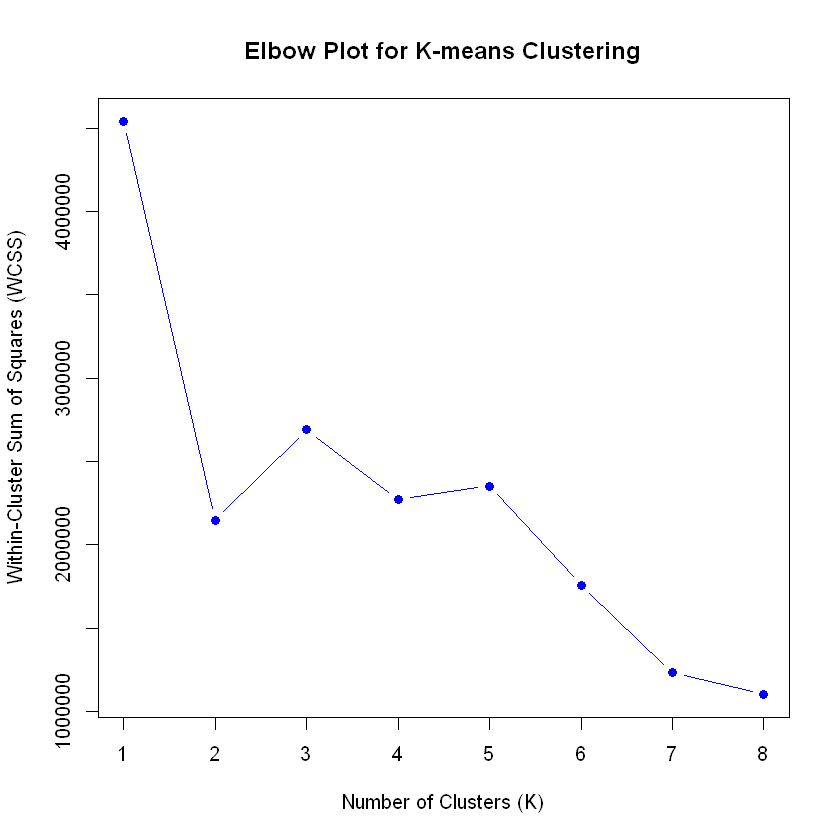

In [10]:
# Calculate WCSS for each K
K_values <- c(1,2,3, 4, 5, 6, 7, 8)
wcss_values <- c()

for(i in 1:length(K_values)) {
  K <- K_values[i]
  k_name <- paste0("K", K)
  
  assignments <- analysis_result$results[[k_name]]$assignments
  raw_data <- analysis_result$raw_data
  
  # Calculate WCSS
  wcss <- 0
  for(k in 1:K) {
    cluster_idx <- which(assignments == k)
    if(length(cluster_idx) > 1) {
      cluster_data <- raw_data[, cluster_idx]
      cluster_mean <- rowMeans(cluster_data)
      wcss <- wcss + sum((cluster_data - cluster_mean)^2)
    }
  }
  
  wcss_values <- c(wcss_values, wcss)
}

# Plot WCSS
plot(K_values, wcss_values, type = "b", 
     xlab = "Number of Clusters (K)", 
     ylab = "Within-Cluster Sum of Squares (WCSS)",
     main = "Elbow Plot for K-means Clustering",
     pch = 19, col = "blue")

# Print values
data.frame(K = K_values, WCSS = wcss_values)

=== CREATING GEOGRAPHIC SST CLUSTER MAPS WITH RIVERS ===
1. Creating individual SST maps...
   Creating SST map for K = 3 
Creating geographic map for SST K = 3 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"Duplicated `override.aes` is ignored."


   Creating SST map for K = 4 
Creating geographic map for SST K = 4 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 


Warning message:
"Duplicated `override.aes` is ignored."


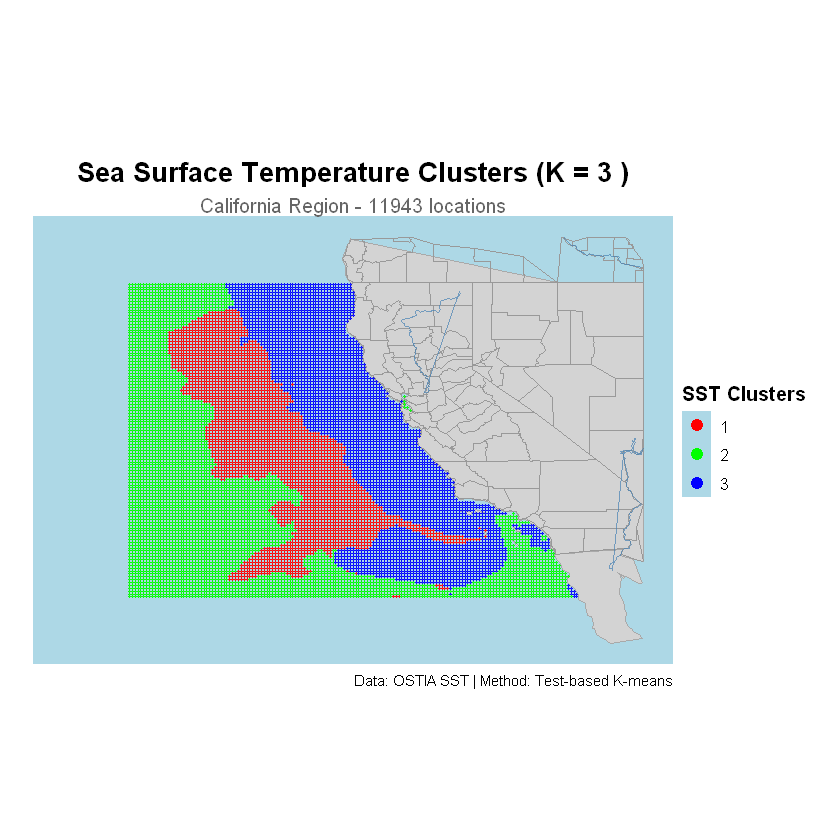

   Creating SST map for K = 5 
Creating geographic map for SST K = 5 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 


Warning message:
"Duplicated `override.aes` is ignored."


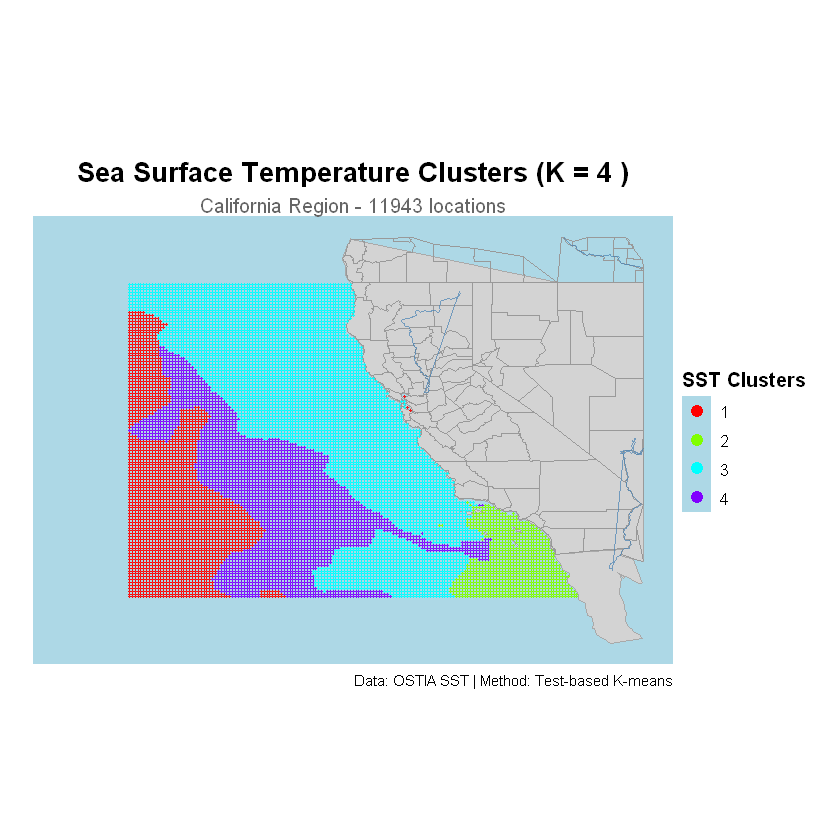

   Creating SST map for K = 6 
Creating geographic map for SST K = 6 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 


Warning message:
"Duplicated `override.aes` is ignored."


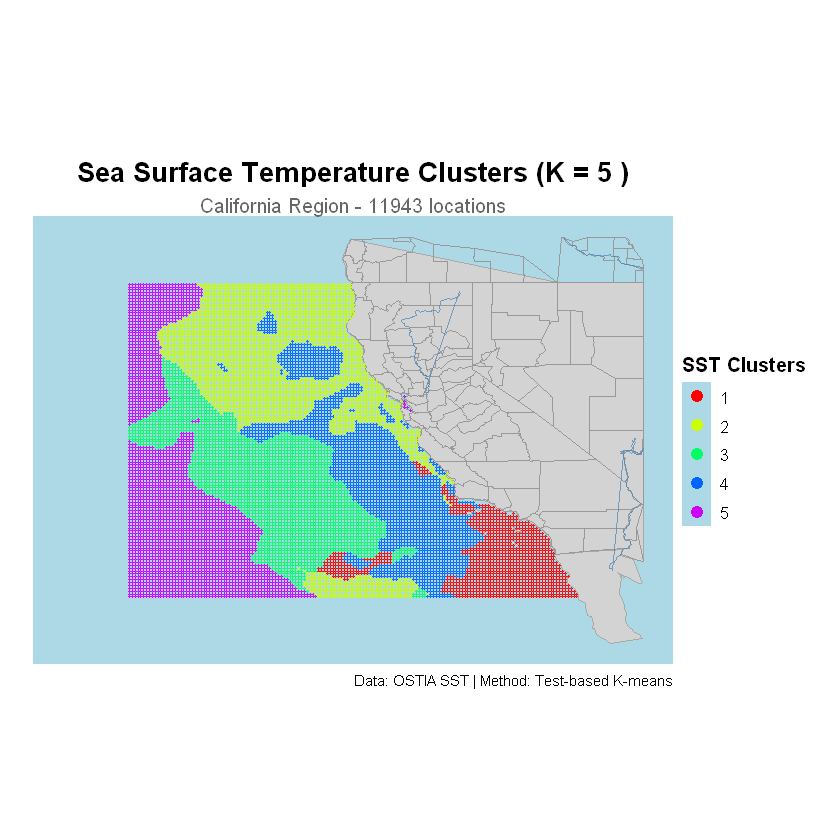

   Creating SST map for K = 7 
Creating geographic map for SST K = 7 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 


Warning message:
"Duplicated `override.aes` is ignored."


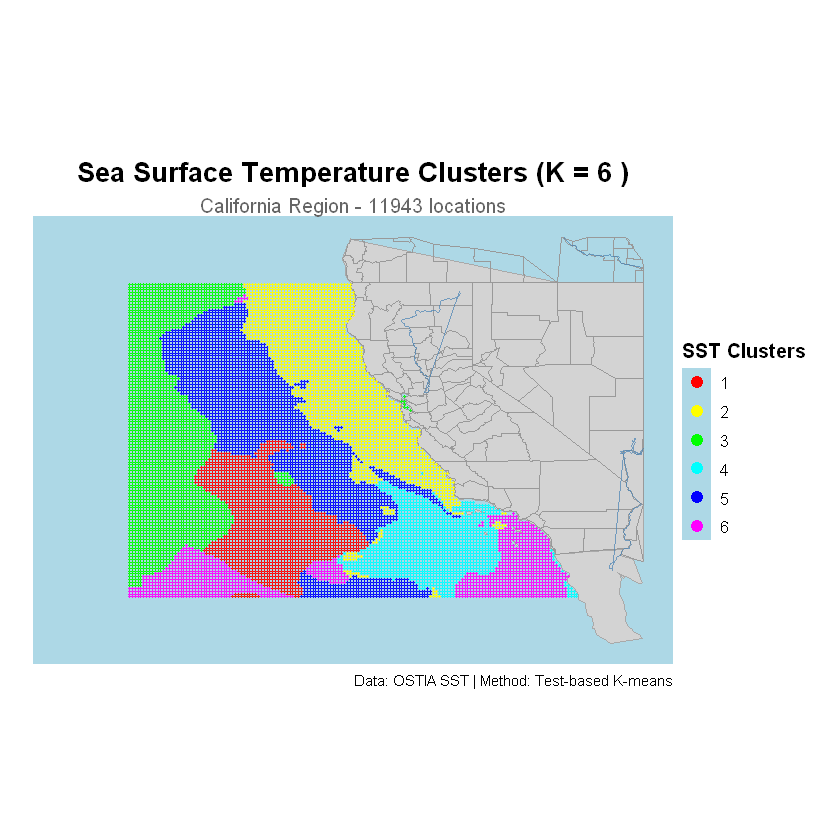

   Creating SST map for K = 8 
Creating geographic map for SST K = 8 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 


Warning message:
"Duplicated `override.aes` is ignored."


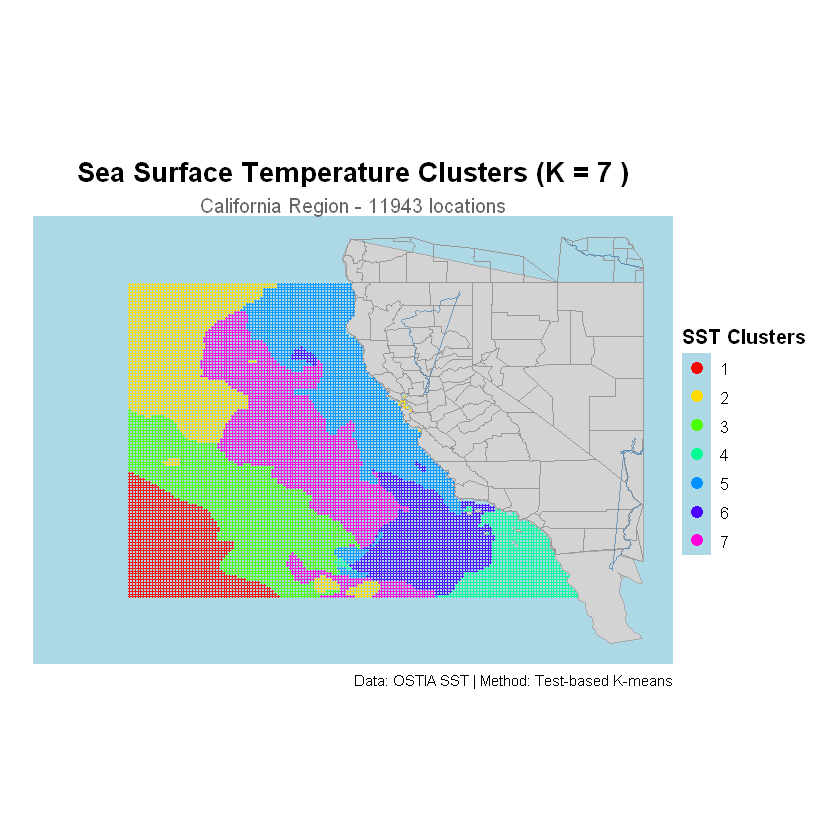


2. Creating detailed SST map with medoids for K = 7...
Creating geographic map for SST K = 7 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 
Finding medoids for K = 7 clusters...
  Cluster 1 : medoid at location 2517 ( -129.75 , 32.35 ) avg dist = 5.543 
  Cluster 2 : medoid at location 2119 ( -130.05 , 39.15 ) avg dist = 9.615 
  Cluster 3 : medoid at location 6029 ( -126.55 , 33.15 ) avg dist = 7.48 
  Cluster 4 : medoid at location 11620 ( -118.25 , 32.05 ) avg dist = 8.472 
  Cluster 5 : medoid at location 8072 ( -124.65 , 37.85 ) avg dist = 13.166 
  Cluster 6 : medoid at location 10354 ( -121.75 , 33.05 ) avg dist = 9.02 
  Cluster 7 : medoid at location 5114 ( -127.35 , 36.65 ) avg dist = 10.75 


Warning message:
"Duplicated `override.aes` is ignored."


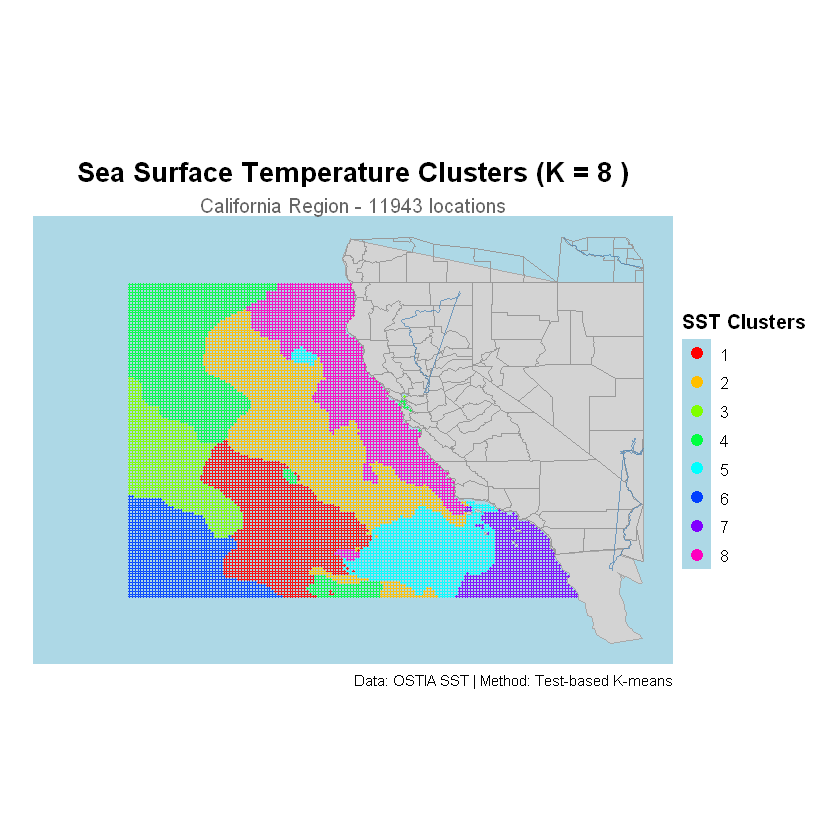


SST Medoid Information:
  cluster medoid_idx     lon   lat cluster_size avg_distance location_id
1       1       2517 -129.75 32.35         1300        5.543        2517
2       2       2119 -130.05 39.15         1862        9.615        2119
3       3       6029 -126.55 33.15         2158        7.480        6029
4       4      11620 -118.25 32.05          793        8.472       15170
5       5       8072 -124.65 37.85         2078       13.166        8072
6       6      10354 -121.75 33.05         1256        9.020       11310
7       7       5114 -127.35 36.65         2496       10.750        5114

3. Creating SST medoid time series plot...
Plotting medoid time series for SST K = 7 
Finding medoids for K = 7 clusters...
  Cluster 1 : medoid at location 2517 ( -129.75 , 32.35 ) avg dist = 5.543 
  Cluster 2 : medoid at location 2119 ( -130.05 , 39.15 ) avg dist = 9.615 
  Cluster 3 : medoid at location 6029 ( -126.55 , 33.15 ) avg dist = 7.48 
  Cluster 4 : medoid at location 11620 

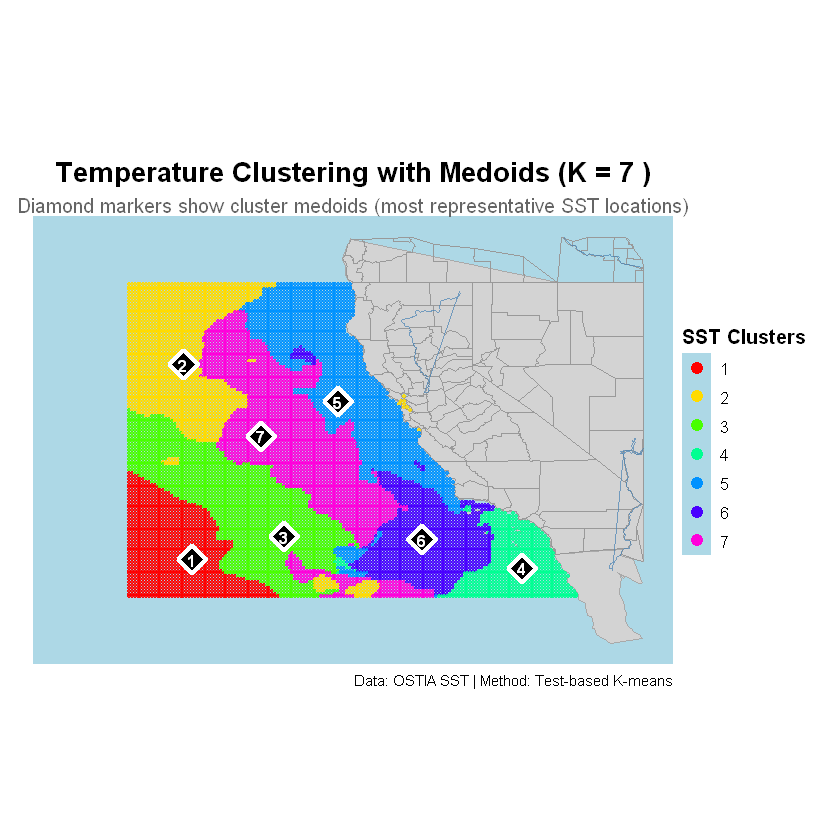


4. Creating SST comparison map...
Creating geographic comparison for K = 3, 4, 5, 6, 7, 8 
Creating geographic map for SST K = 3 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 
Creating geographic map for SST K = 4 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 
Creating geographic map for SST K = 5 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 
Creating geographic map for SST K = 6 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 
Creating geographic map for SST K = 7 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 
Creating geographic map for SST K = 8 
Plotting 11943 SST locations
Longitude range: -131.95 -116.35 
Latitude range: 31.05 41.95 


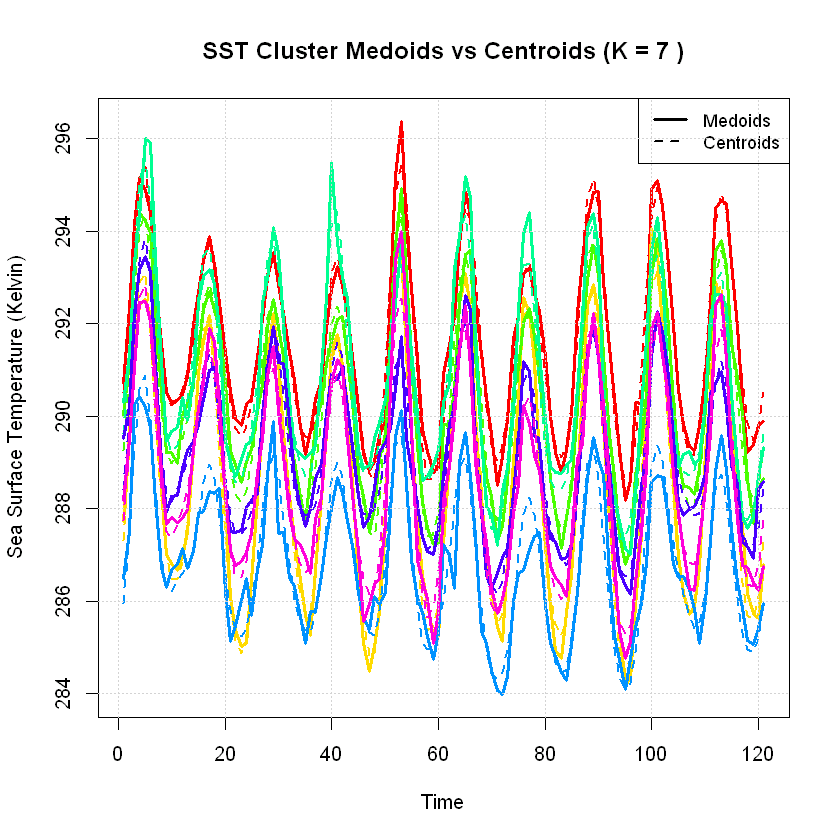


=== SST GEOGRAPHIC MAPPING WITH RIVERS COMPLETE ===
Analysis shows sst patterns in relation to:
- Coastlines and river mouths (freshwater input)
- State/county boundaries
- Medoids represent most typical sst locations per cluster


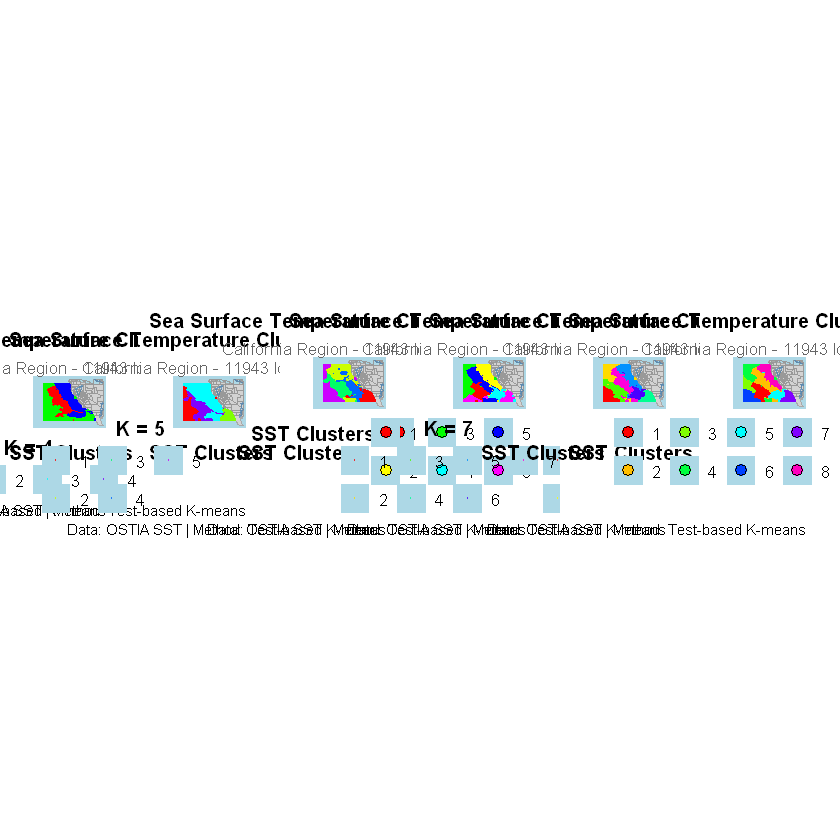

In [11]:
# Geographic Cluster Map with Coastlines and Rivers - Sea Surface Salinity
library(ggplot2)
library(maps)
library(mapdata)

# Function to create professional geographic map
create_geographic_cluster_map <- function(analysis_result, K = 7, point_size = 0.8) {
  
  cat("Creating geographic map for SST K =", K, "\n")
  
  # Extract clustering data
  cluster_result <- analysis_result$results[[paste0("K", K)]]
  assignments <- cluster_result$assignments
  coords <- analysis_result$coords
  
  # Create spatial dataframe
  cluster_data <- data.frame(
    longitude = coords$longitude,
    latitude = coords$latitude,
    cluster = factor(assignments),
    location_id = coords$location
  )
  
  # Print data info
  cat("Plotting", nrow(cluster_data), "SST locations\n")
  cat("Longitude range:", round(range(cluster_data$longitude), 2), "\n")
  cat("Latitude range:", round(range(cluster_data$latitude), 2), "\n")
  
  # Calculate map bounds with buffer
  lon_range <- range(cluster_data$longitude, na.rm = TRUE)
  lat_range <- range(cluster_data$latitude, na.rm = TRUE)
  
  # Add 15% buffer for better view
  lon_buffer <- diff(lon_range) * 0.15
  lat_buffer <- diff(lat_range) * 0.15
  
  map_bounds <- list(
    xmin = lon_range[1] - lon_buffer,
    xmax = lon_range[2] + lon_buffer,
    ymin = lat_range[1] - lat_buffer,
    ymax = lat_range[2] + lat_buffer
  )
  
  # Get detailed map data for the region
  # Use world map for coastlines
  world_map <- map_data("world")
  
  # Get state boundaries (for US Gulf Coast)
  states_map <- map_data("state")
  
  # Get county data for more detailed features including rivers
  counties_map <- map_data("county")
  
  # Try to get river data (if available)
  rivers_map <- NULL
  tryCatch({
    # This may not work in all installations
    rivers_map <- map_data("rivers")
  }, error = function(e) {
    cat("Note: Detailed river data not available, using county boundaries for detail\n")
  })
  
  # Filter map data to our region
  world_region <- subset(world_map, 
                        long >= map_bounds$xmin & long <= map_bounds$xmax &
                        lat >= map_bounds$ymin & lat <= map_bounds$ymax)
  
  states_region <- subset(states_map, 
                         long >= map_bounds$xmin & long <= map_bounds$xmax &
                         lat >= map_bounds$ymin & lat <= map_bounds$ymax)
  
  counties_region <- subset(counties_map, 
                           long >= map_bounds$xmin & long <= map_bounds$xmax &
                           lat >= map_bounds$ymin & lat <= map_bounds$ymax)
  
  # Filter rivers if available
  rivers_region <- NULL
  if(!is.null(rivers_map)) {
    rivers_region <- subset(rivers_map, 
                           long >= map_bounds$xmin & long <= map_bounds$xmax &
                           lat >= map_bounds$ymin & lat <= map_bounds$ymax)
  }
  
  # Set up colors for clusters
  cluster_colors <- rainbow(K, s = 1, v = 1)
  
  # Create the map
  p <- ggplot() +
    # Ocean background
    theme_void() +
    theme(
      panel.background = element_rect(fill = "lightblue", color = NA),
      plot.background = element_rect(fill = "white", color = NA),
      plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5, size = 12, color = "gray40"),
      legend.position = "right",
      legend.title = element_text(size = 12, face = "bold"),
      legend.text = element_text(size = 10),
      plot.margin = margin(20, 20, 20, 20)
    ) +
    
    # Land masses (countries)
    geom_polygon(data = world_region, 
                aes(x = long, y = lat, group = group), 
                fill = "lightgray", 
                color = "darkgray", 
                size = 0.3) +
    
    # State boundaries (finer detail for US coast)
    geom_polygon(data = states_region, 
                aes(x = long, y = lat, group = group), 
                fill = "lightgray", 
                color = "darkgray", 
                size = 0.2) +
    
    # County boundaries for detailed coastal features
    geom_polygon(data = counties_region, 
                aes(x = long, y = lat, group = group), 
                fill = NA, 
                color = "gray60", 
                size = 0.1) +
    
    # Add rivers if available
    {if(!is.null(rivers_region) && nrow(rivers_region) > 0) {
      geom_path(data = rivers_region, 
               aes(x = long, y = lat, group = group), 
               color = "steelblue", 
               size = 0.5,
               alpha = 0.7)
    }} +
    
    # Cluster points
    geom_point(data = cluster_data, 
              aes(x = longitude, y = latitude, color = cluster, fill = cluster),
              size = point_size, 
              alpha = 0.8,
              stroke = 0.1,
              shape = 21) +
    
    # Set coordinate limits
    coord_fixed(ratio = 1, 
                xlim = c(map_bounds$xmin, map_bounds$xmax),
                ylim = c(map_bounds$ymin, map_bounds$ymax)) +
    
    # Color scheme
    scale_color_manual(values = cluster_colors, name = "Cluster") +
    scale_fill_manual(values = cluster_colors, name = "Cluster") +
    
    # Labels - Updated for SSS
    labs(
      title = paste("Sea Surface Temperature Clusters (K =", K, ")"),
      subtitle = paste("California Region -", nrow(cluster_data), "locations"),
      caption = "Data: OSTIA SST | Method: Test-based K-means"
    )
  
  # Add cluster size information to legend
  cluster_sizes <- table(assignments)
  legend_labels <- paste0("Cluster ", 1:K, " (n=", cluster_sizes, ")")
  
  p <- p + guides(
    color = guide_legend(
      title = "SST Clusters",
      labels = legend_labels,
      override.aes = list(size = 3, alpha = 1)
    ),
    fill = guide_legend(
      title = "SST Clusters",
      labels = legend_labels,
      override.aes = list(size = 3, alpha = 1, shape = 21, stroke = 0.5)
    )
  )
  
  return(p)
}

# Function to create comparison map across multiple K values
create_multi_K_geographic_map <- function(analysis_result, K_values = c(3,4,5,6, 7, 8)) {
  
  cat("Creating geographic comparison for K =", paste(K_values, collapse = ", "), "\n")
  
  # Create individual maps
  map_list <- list()
  
  for(i in 1:length(K_values)) {
    K <- K_values[i]
    map_list[[i]] <- create_geographic_cluster_map(analysis_result, K, point_size = 0.6) +
      theme(
        legend.position = "bottom",
        legend.box = "horizontal",
        plot.title = element_text(size = 12),
        plot.subtitle = element_text(size = 10)
      ) +
      guides(
        color = guide_legend(
          title = paste("K =", K),
          ncol = min(K, 4),
          title.position = "top",
          title.hjust = 0.5
        )
      )
  }
  
  # Combine maps (this requires gridExtra or patchwork)
  if(require(gridExtra, quietly = TRUE)) {
    combined_map <- do.call(gridExtra::grid.arrange, c(map_list, ncol = length(K_values)))
    return(combined_map)
  } else {
    # If gridExtra not available, return individual maps
    cat("Note: Install 'gridExtra' package to combine maps\n")
    return(map_list)
  }
}

# Function to find cluster medoids
find_cluster_medoids <- function(analysis_result, K) {
  
  cat("Finding medoids for K =", K, "clusters...\n")
  
  cluster_result <- analysis_result$results[[paste0("K", K)]]
  assignments <- cluster_result$assignments
  coords <- analysis_result$coords
  raw_data <- analysis_result$raw_data
  centers <- cluster_result$centers
  time_points <- analysis_result$time_points
  
  medoid_info <- data.frame()
  
  for(k in 1:K) {
    cluster_idx <- which(assignments == k)
    n_cluster <- length(cluster_idx)
    
    if(n_cluster == 0) next
    
    if(n_cluster == 1) {
      # Only one point in cluster
      medoid_idx <- cluster_idx[1]
    } else {
      # Find the point closest to the cluster centroid
      cluster_data <- raw_data[, cluster_idx, drop = FALSE]
      cluster_centroid <- centers[, k]
      
      # Calculate distances from each point to the centroid
      distances <- numeric(n_cluster)
      for(i in 1:n_cluster) {
        point_idx <- cluster_idx[i]
        point_data <- raw_data[, point_idx]
        # Euclidean distance in time series space
        distances[i] <- sqrt(sum((point_data - cluster_centroid)^2))
      }
      
      # Find the point with minimum distance (medoid)
      medoid_position <- which.min(distances)
      medoid_idx <- cluster_idx[medoid_position]
    }
    
    # Get medoid coordinates and info
    medoid_coords <- coords[medoid_idx, ]
    medoid_data <- raw_data[, medoid_idx]
    
    # Calculate how representative this medoid is
    avg_distance_to_medoid <- 0
    if(n_cluster > 1) {
      cluster_data <- raw_data[, cluster_idx, drop = FALSE]
      distances_to_medoid <- numeric(n_cluster)
      for(i in 1:n_cluster) {
        point_data <- raw_data[, cluster_idx[i]]
        distances_to_medoid[i] <- sqrt(sum((point_data - medoid_data)^2))
      }
      avg_distance_to_medoid <- mean(distances_to_medoid)
    }
    
    medoid_info <- rbind(medoid_info, data.frame(
      cluster = k,
      medoid_idx = medoid_idx,
      lon = medoid_coords$longitude,
      lat = medoid_coords$latitude,
      cluster_size = n_cluster,
      avg_distance = round(avg_distance_to_medoid, 3),
      location_id = medoid_coords$location
    ))
    
    cat("  Cluster", k, ": medoid at location", medoid_idx, 
        "(", round(medoid_coords$longitude, 3), ",", round(medoid_coords$latitude, 3), ")",
        "avg dist =", round(avg_distance_to_medoid, 3), "\n")
  }
  
  return(medoid_info)
}

# Function to create detailed single K map with medoids
create_detailed_geographic_map <- function(analysis_result, K = 7) {
  
  # Get the basic map
  base_map <- create_geographic_cluster_map(analysis_result, K, point_size = 1.0)
  
  # Find cluster medoids
  medoid_info <- find_cluster_medoids(analysis_result, K)
  
  # Add medoids and labels to the map
  enhanced_map <- base_map +
    # Add medoid points (larger, distinctive)
    geom_point(data = medoid_info,
              aes(x = lon, y = lat),
              size = 5, 
              color = "white", 
              fill = "black", 
              shape = 23,  # Diamond shape for medoids
              stroke = 2) +
    
    # Add cluster labels
    geom_text(data = medoid_info,
             aes(x = lon, y = lat, label = cluster),
             color = "white", 
             size = 3.5, 
             fontface = "bold") +
    
    # Enhanced title
    labs(
      title = paste("Temperature Clustering with Medoids (K =", K, ")"),
      subtitle = "Diamond markers show cluster medoids (most representative SST locations)"
    )
  
  return(list(map = enhanced_map, medoids = medoid_info))
}

# Function to plot medoid time series
plot_medoid_time_series <- function(analysis_result, K = 5) {
  
  cat("Plotting medoid time series for SST K =", K, "\n")
  
  # Find medoids
  medoid_info <- find_cluster_medoids(analysis_result, K)
  
  raw_data <- analysis_result$raw_data
  time_points <- analysis_result$time_points
  centers <- analysis_result$results[[paste0("K", K)]]$centers
  
  # Set up colors
  colors <- rainbow(K)
  
  # Create plot
  plot(time_points, raw_data[, medoid_info$medoid_idx[1]], 
       type = "n",
       ylim = range(raw_data[, medoid_info$medoid_idx], na.rm = TRUE),
       xlab = "Time", 
       ylab = "Sea Surface Temperature (Kelvin)",  # Updated for salinity units
       main = paste("SST Cluster Medoids vs Centroids (K =", K, ")"))
  
  # Plot each medoid and centroid
  for(k in 1:K) {
    medoid_idx <- medoid_info$medoid_idx[k]
    medoid_data <- raw_data[, medoid_idx]
    centroid_data <- centers[, k]
    
    # Plot medoid (thick solid line)
    lines(time_points, medoid_data, col = colors[k], lwd = 3, lty = 1)
    
    # Plot centroid (dashed line)
    lines(time_points, centroid_data, col = colors[k], lwd = 2, lty = 2)
  }
  
  # Add legend
  legend("topright", 
         legend = c("Medoids", "Centroids"),
         lty = c(1, 2),
         lwd = c(3, 2),
         cex = 0.9)
  
  # Add grid
  grid(col = "lightgray", lty = "dotted")
  
  return(medoid_info)
}

# Execute the geographic mapping with medoids
cat("=== CREATING GEOGRAPHIC SST CLUSTER MAPS WITH RIVERS ===\n")

if(exists("analysis_result")) {
  
  # 1. Create individual maps for each K
  cat("1. Creating individual SST maps...\n")
  for(K in c(3,4,5,6, 7, 8)) {
    cat("   Creating SST map for K =", K, "\n")
    map_plot <- create_geographic_cluster_map(analysis_result, K)
    print(map_plot)
  }
  
  # 2. Create detailed map with medoids for K=7 (or your preferred K)
  cat("\n2. Creating detailed SST map with medoids for K = 7...\n")
  detailed_result <- create_detailed_geographic_map(analysis_result, K = 7)
  print(detailed_result$map)
  
  # Print medoid information
  cat("\nSST Medoid Information:\n")
  print(detailed_result$medoids)
  
  # 3. Plot medoid time series comparison
  cat("\n3. Creating SST medoid time series plot...\n")
  medoid_info <- plot_medoid_time_series(analysis_result, K = 7)
  
  # 4. Try to create comparison map
  cat("\n4. Creating SST comparison map...\n")
  if(require(gridExtra, quietly = TRUE)) {
    multi_map <- create_multi_K_geographic_map(analysis_result, c(3,4,5,6, 7, 8))
  } else {
    cat("Install 'gridExtra' package for side-by-side comparison\n")
  }
  
  cat("\n=== SST GEOGRAPHIC MAPPING WITH RIVERS COMPLETE ===\n")
  cat("Analysis shows sst patterns in relation to:\n")
  cat("- Coastlines and river mouths (freshwater input)\n") 
  cat("- State/county boundaries\n")
  cat("- Medoids represent most typical sst locations per cluster\n")
  
} else {
  cat("Error: analysis_result not found. Please run the SST clustering analysis first.\n")
}

Extracting medoids and plotting clusters for K = 7 
Using standardized y-axis range for better comparison across clusters
=== Extracting Medoids and Plotting Clusters for K = 7 ===
Using standardized y-axis range: [ 280.95 ,  298.47 ]
Calculating medoids for 7 clusters...
  Cluster 1 : 1300 curves
    Medoid index: 2517 with distance: 3.744 
  Cluster 2 : 1862 curves
    Medoid index: 2119 with distance: 4.28 
  Cluster 3 : 2158 curves
    Medoid index: 6029 with distance: 4.374 
  Cluster 4 : 793 curves
    Medoid index: 11620 with distance: 4.95 
  Cluster 5 : 2078 curves
    Medoid index: 8072 with distance: 5.461 
  Cluster 6 : 1256 curves
    Medoid index: 10354 with distance: 4.384 
  Cluster 7 : 2496 curves
    Medoid index: 5114 with distance: 4.998 
Creating cluster visualizations...


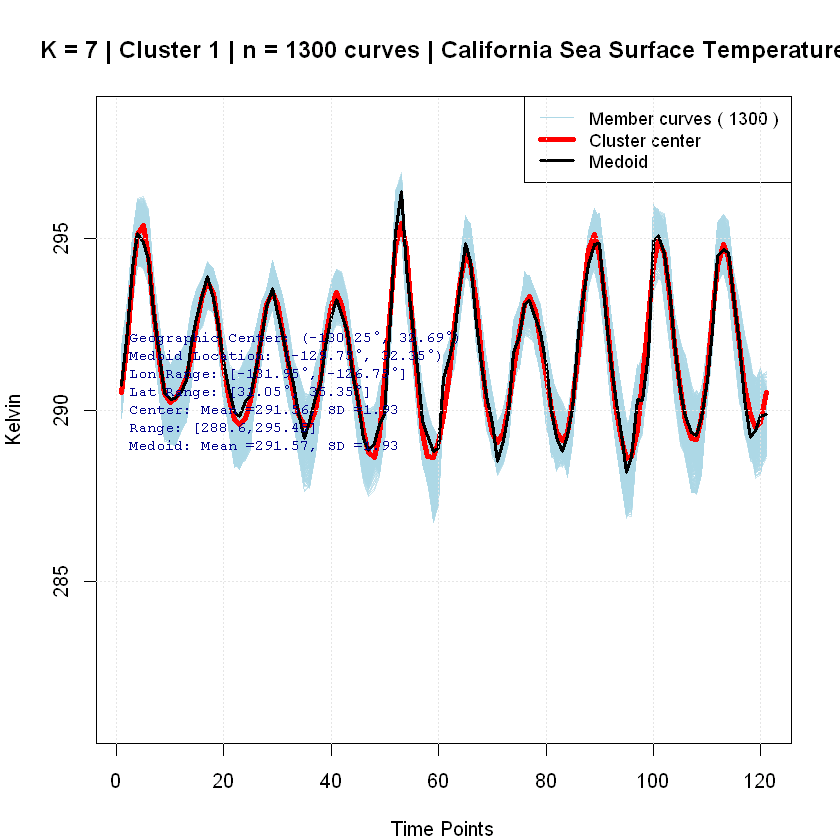

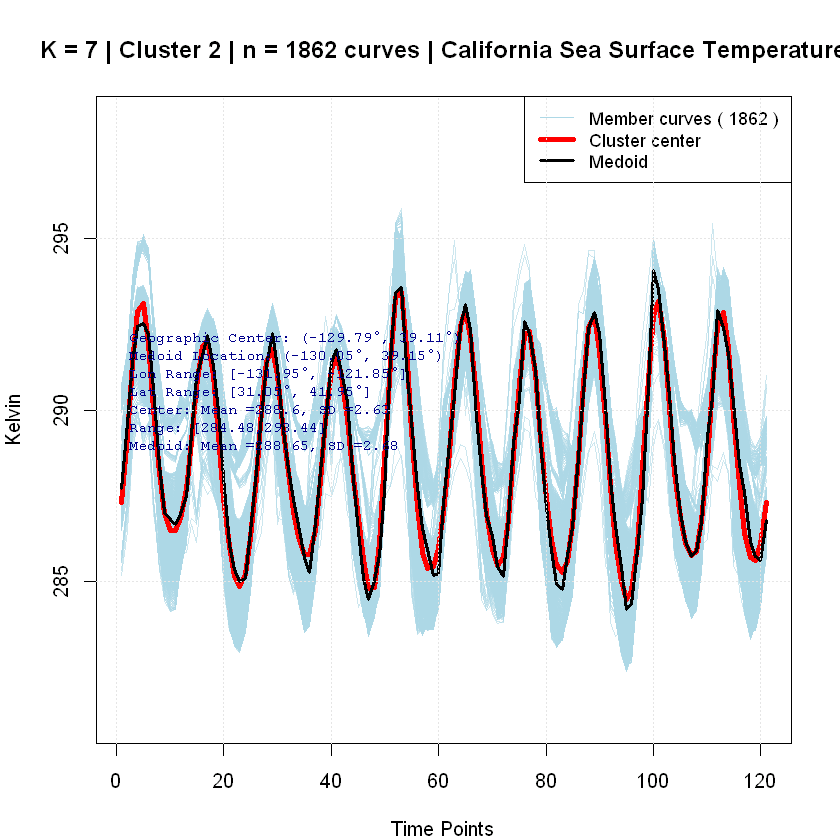

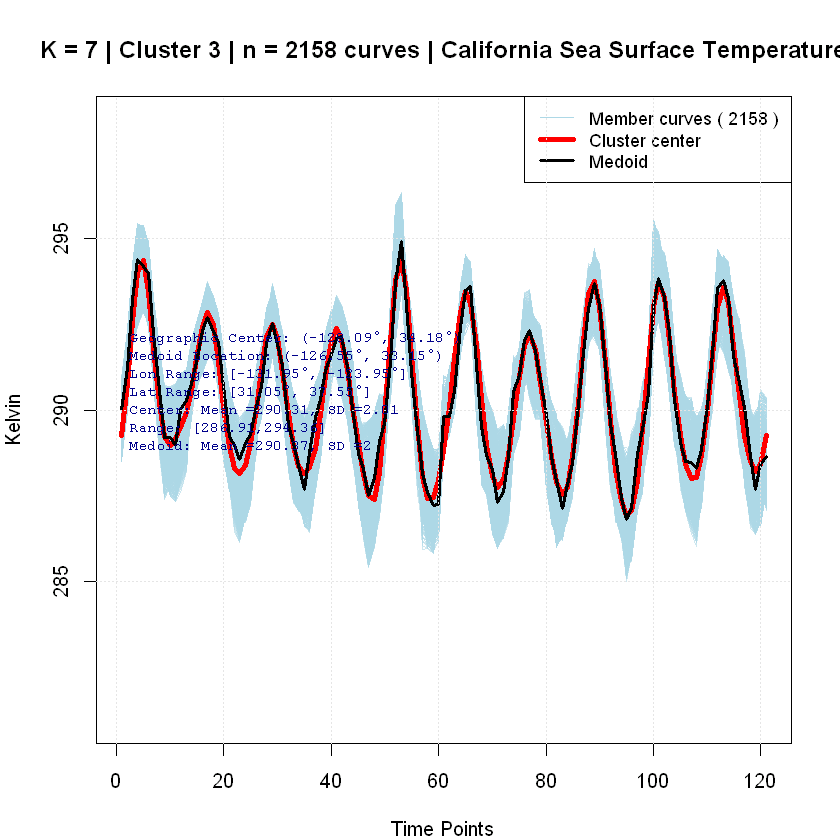

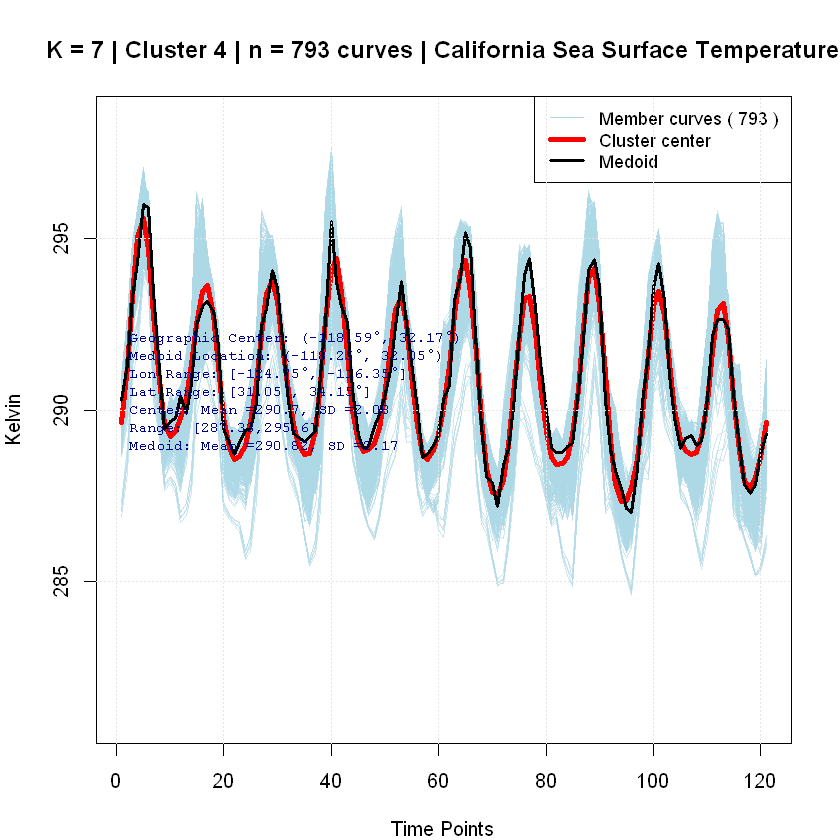

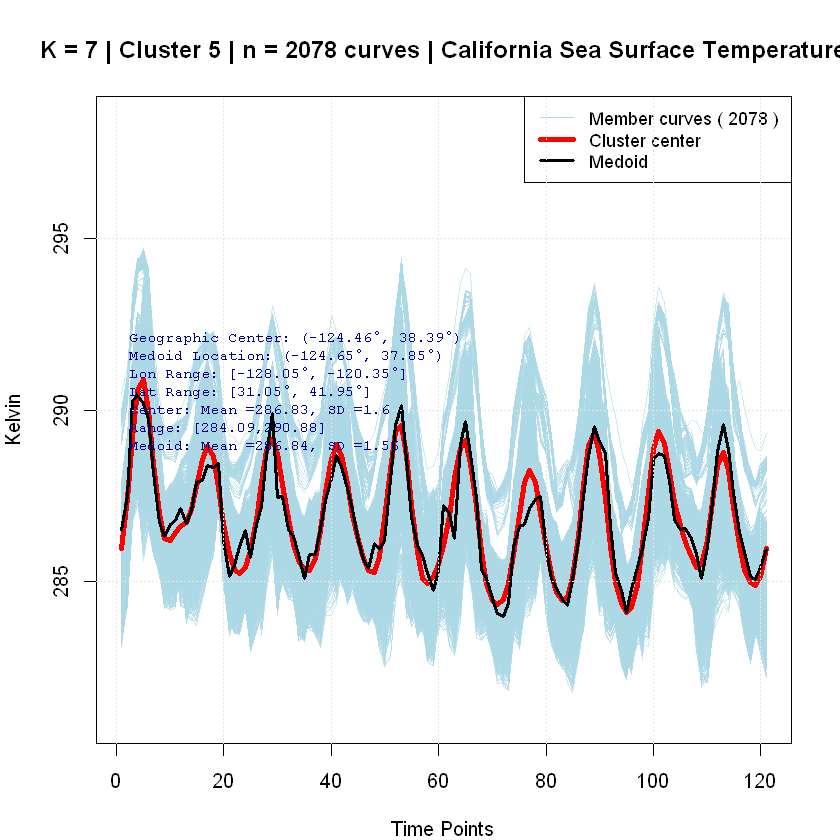

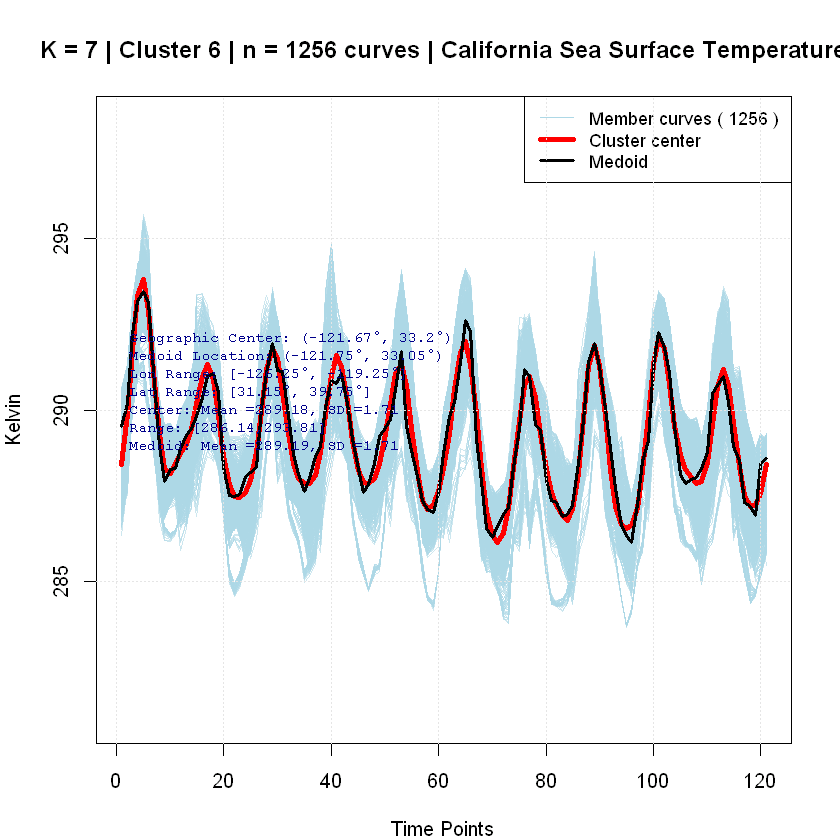


=== Medoid Summary ===
  cluster medoid_index cluster_size longitude latitude
1       1         2517         1300   -129.75    32.35
2       2         2119         1862   -130.05    39.15
3       3         6029         2158   -126.55    33.15
4       4        11620          793   -118.25    32.05
5       5         8072         2078   -124.65    37.85
6       6        10354         1256   -121.75    33.05
7       7         5114         2496   -127.35    36.65


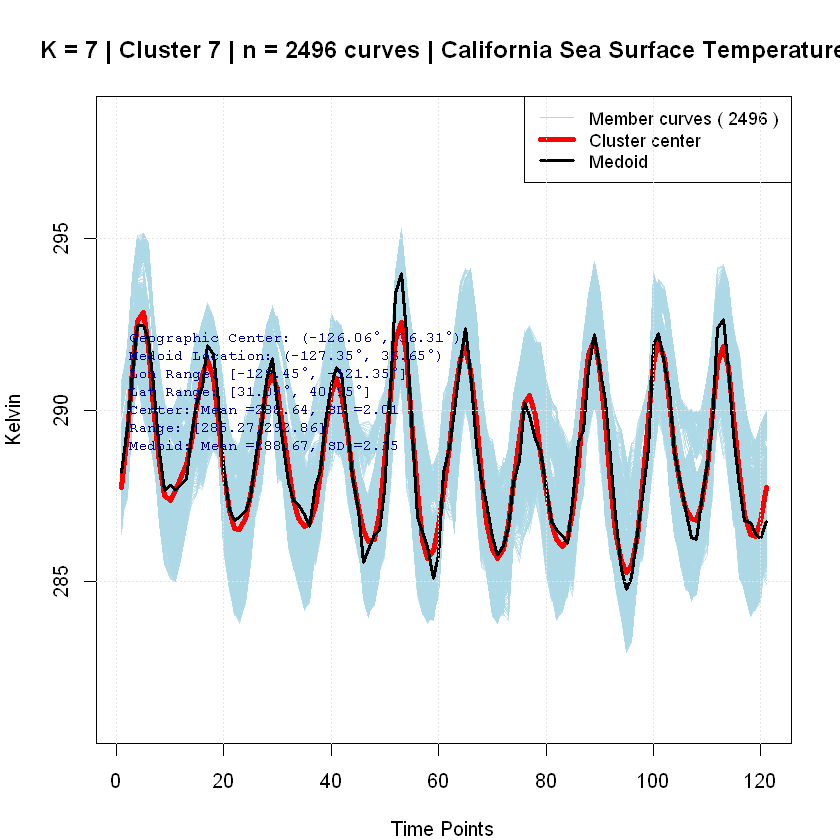

In [13]:
# Cell 8: Extract Medoids and Visualize All Cluster Members

extract_medoids_and_plot <- function(analysis_result, K, standardize_axes = TRUE) {
  cat("=== Extracting Medoids and Plotting Clusters for K =", K, "===\n")
  
  # Get the results for the specified K
  k_name <- paste0("K", K)
  if(!k_name %in% names(analysis_result$results)) {
    cat("Error: K =", K, "not found in results. Available K values:", 
        gsub("K", "", names(analysis_result$results)), "\n")
    return(NULL)
  }
  
  # Extract data
  kmeans_result <- analysis_result$results[[k_name]]
  assignments <- kmeans_result$assignments
  centers_eval <- kmeans_result$centers
  raw_data <- analysis_result$raw_data
  time_points <- analysis_result$time_points
  coords <- analysis_result$coords
  
  n_time <- length(time_points)
  
  # Calculate global y-axis range for standardization
  if(standardize_axes) {
    global_y_range <- range(raw_data, na.rm = TRUE)
    y_padding <- (global_y_range[2] - global_y_range[1]) * 0.05
    global_y_range <- c(global_y_range[1] - y_padding, global_y_range[2] + y_padding)
    cat("Using standardized y-axis range: [", round(global_y_range[1], 2), ", ", 
        round(global_y_range[2], 2), "]\n")
  }
  
  # Calculate medoids for each cluster
  cat("Calculating medoids for", K, "clusters...\n")
  medoid_indices <- numeric(K)
  
  for(k in 1:K) {
    cluster_indices <- which(assignments == k)
    cat("  Cluster", k, ":", length(cluster_indices), "curves\n")
    
    if(length(cluster_indices) > 1) {
      # Calculate distances from each curve to the cluster center
      cluster_data <- raw_data[, cluster_indices]
      center_k <- centers_eval[, k]
      
      distances <- numeric(length(cluster_indices))
      for(i in 1:length(cluster_indices)) {
        distances[i] <- sqrt(sum((cluster_data[, i] - center_k)^2))
      }
      
      # Find the curve closest to center (medoid)
      medoid_idx_in_cluster <- which.min(distances)
      medoid_indices[k] <- cluster_indices[medoid_idx_in_cluster]
      
      cat("    Medoid index:", medoid_indices[k], "with distance:", 
          round(distances[medoid_idx_in_cluster], 3), "\n")
    } else {
      # Single curve case
      medoid_indices[k] <- cluster_indices[1]
      cat("    Single curve cluster - medoid index:", medoid_indices[k], "\n")
    }
  }
  
  # Create visualization
  cat("Creating cluster visualizations...\n")
  
  # Set up colors
  cluster_colors <- rainbow(K)
  
  for(k in 1:K) {
    cluster_indices <- which(assignments == k)
    cluster_data <- raw_data[, cluster_indices]
    medoid_idx <- medoid_indices[k]
    
    # Use standardized or cluster-specific y-axis range
    if(standardize_axes) {
      y_range <- global_y_range
    } else {
      # Calculate y-axis range for this cluster only
      y_range <- range(cluster_data, na.rm = TRUE)
      y_padding <- (y_range[2] - y_range[1]) * 0.1
      y_range <- c(y_range[1] - y_padding, y_range[2] + y_padding)
    }
    
    # Create the plot with standardized or cluster-specific range
    par(mfrow = c(1, 1), mar = c(4, 4, 4, 2))
    plot_title <- paste("K =", K, "| Cluster", k, "| n =", length(cluster_indices), "curves")
    if(standardize_axes) {
      plot_title <- paste(plot_title, "| California Sea Surface Temperature")
    }
    
    plot(1, type="n", xlim=c(1, n_time), ylim=y_range,
         main = plot_title,
         xlab = "Time Points", ylab = "Kelvin")
    
    # Plot all member curves (semi-transparent)
    for(i in 1:length(cluster_indices)) {
      curve_idx <- cluster_indices[i]
      lines(time_points, raw_data[, curve_idx], 
            col = adjustcolor("lightblue", alpha = 0.6), lwd = 0.8)
    }
    
    # Plot cluster center (thick red line)
    lines(time_points, centers_eval[, k], col = "red", lwd = 4)
    
    # Plot medoid (thick black line)
    lines(time_points, raw_data[, medoid_idx], col = "black", lwd = 3)
    
    # Add legend
    legend("topright", 
           legend = c(paste("Member curves (", length(cluster_indices), ")"), 
                     "Cluster center", "Medoid"),
           col = c("lightblue", "red", "black"), 
           lwd = c(1, 4, 3), 
           cex = 0.9,
           bg = "white")
    
    # Add grid for better readability
    grid(col = "gray90", lty = "dotted")
    
    # Calculate and display cluster statistics
    if(ncol(coords) >= 3) {  # Check if coordinates are available
      cluster_coords <- coords[cluster_indices, ]
      mean_lon <- round(mean(cluster_coords$longitude), 2)
      mean_lat <- round(mean(cluster_coords$latitude), 2)
      lon_range <- round(range(cluster_coords$longitude), 2)
      lat_range <- round(range(cluster_coords$latitude), 2)
      
      # Add medoid coordinates
      medoid_coords <- coords[medoid_idx, ]
      medoid_lon <- round(medoid_coords$longitude, 2)
      medoid_lat <- round(medoid_coords$latitude, 2)
      
      # Add statistics text box
      text_info <- paste(
        "Geographic Center: (", mean_lon, "°, ", mean_lat, "°)\n",
        "Medoid Location: (", medoid_lon, "°, ", medoid_lat, "°)\n",
        "Lon Range: [", lon_range[1], "°, ", lon_range[2], "°]\n",
        "Lat Range: [", lat_range[1], "°, ", lat_range[2], "°]",
        sep = ""
      )
    } else {
      # No coordinate information available
      text_info <- paste(
        "Cluster Size: ", length(cluster_indices), " curves\n",
        "Medoid Index: ", medoid_idx,
        sep = ""
      )
    }
    
    # Calculate temporal statistics
    center_mean <- round(mean(centers_eval[, k], na.rm = TRUE), 2)
    center_sd <- round(sd(centers_eval[, k], na.rm = TRUE), 2)
    center_min <- round(min(centers_eval[, k], na.rm = TRUE), 2)
    center_max <- round(max(centers_eval[, k], na.rm = TRUE), 2)
    
    medoid_mean <- round(mean(raw_data[, medoid_idx], na.rm = TRUE), 2)
    medoid_sd <- round(sd(raw_data[, medoid_idx], na.rm = TRUE), 2)
    
    # Add temporal stats
    temp_info <- paste(
      "\nCenter: Mean =", center_mean, ", SD =", center_sd,
      "\nRange: [", center_min, ",", center_max, "]",
      "\nMedoid: Mean =", medoid_mean, ", SD =", medoid_sd,
      sep = ""
    )
    
    full_text_info <- paste(text_info, temp_info, sep = "")
    
    # Position text box in bottom left
    text(x = n_time * 0.02, y = y_range[1] + (y_range[2] - y_range[1]) * 0.45, 
         labels = full_text_info,
         adj = c(0, 0), cex = 0.75, col = "darkblue",
         bg = "white", family = "mono")
  }
  
  # Return medoid information
  medoid_info <- data.frame(
    cluster = 1:K,
    medoid_index = medoid_indices,
    cluster_size = as.numeric(table(assignments))
  )
  
  if(ncol(coords) >= 3) {
    medoid_coords <- coords[medoid_indices, ]
    medoid_info$longitude <- medoid_coords$longitude
    medoid_info$latitude <- medoid_coords$latitude
  }
  
  cat("\n=== Medoid Summary ===\n")
  print(medoid_info)
  
  return(list(
    medoid_indices = medoid_indices,
    medoid_info = medoid_info,
    cluster_assignments = assignments
  ))
}

# Example usage - extract medoids and plot for optimal K
if(exists("analysis_result")) {
  # Get the optimal K from previous analysis
  if(exists("optimal_K")) {
    selected_K <- optimal_K
  } else {
    # Default to K=5 if optimal_K not defined
    selected_K <- 7
  }
  
  cat("Extracting medoids and plotting clusters for K =", selected_K, "\n")
  cat("Using standardized y-axis range for better comparison across clusters\n")
  medoid_result <- extract_medoids_and_plot(analysis_result, selected_K, standardize_axes = TRUE)
  
  # You can also test other K values like this:
  # medoid_result_K4 <- extract_medoids_and_plot(analysis_result, 4, standardize_axes = TRUE)
  # medoid_result_K6 <- extract_medoids_and_plot(analysis_result, 6, standardize_axes = TRUE)
  
  # Or use cluster-specific ranges (original behavior):
  # medoid_result_custom <- extract_medoids_and_plot(analysis_result, selected_K, standardize_axes = FALSE)
  
} else {
  cat("Error: analysis_result not found. Please run the main analysis first (Cell 7).\n")
  cat("This function requires the output from run_smap_clustering() or the loaded .RData file.\n")
}

# Additional function to compare medoids across different K values
compare_medoids_across_K <- function(analysis_result, K_values, standardize_axes = TRUE) {
  cat("=== Comparing Medoids Across Different K Values ===\n")
  
  medoid_comparison <- list()
  
  for(K in K_values) {
    cat("\n--- K =", K, "---\n")
    medoid_result <- extract_medoids_and_plot(analysis_result, K, standardize_axes = standardize_axes)
    medoid_comparison[[paste0("K", K)]] <- medoid_result$medoid_info
  }
  
  return(medoid_comparison)
}

# Example: Compare medoids across multiple K values with standardized axes
# if(exists("analysis_result")) {
#   medoid_comparison <- compare_medoids_across_K(analysis_result, c(3, 4, 5, 6), standardize_axes = TRUE)
# }